In [1]:

import os
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import cv2
import numpy as np
from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# HAM FF++ klasörü 
RAW_DATA_ROOT = r"c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\FaceForensics++_C23"

# Train/val/test için hedef klasör
DATA_ROOT = r"c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\data_ffpp_c23"

print("RAW_DATA_ROOT:", RAW_DATA_ROOT)
print("DATA_ROOT:", DATA_ROOT)


Using device: cuda
RAW_DATA_ROOT: c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\FaceForensics++_C23
DATA_ROOT: c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\data_ffpp_c23


In [2]:

print("CUDA available:", torch.cuda.is_available())
print("Visible devices:", os.environ.get("CUDA_VISIBLE_DEVICES"))
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Device 0:", torch.cuda.get_device_name(0))


CUDA available: True
Visible devices: None
Device count: 1
Device 0: NVIDIA GeForce RTX 3060 Laptop GPU


ÖNİŞLEME

In [3]:


VIDEO_ROOT = RAW_DATA_ROOT  # mp4'lerin olduğu klasör: FaceForensics++_C23

FRAMES_ROOT = r"e:\bitirme"
os.makedirs(FRAMES_ROOT, exist_ok=True)
print("FRAMES_ROOT:", FRAMES_ROOT)

VIDEO_CLASSES = [
    "original",
    "Deepfakes",
    "Face2Face",
    "FaceSwap",
    "NeuralTextures",
    "DeepFakeDetection",
    "FaceShifter",
]

FRAMES_PER_VIDEO = 20  

def extract_frames_from_video(video_path, out_dir, frames_per_video=20):
    os.makedirs(out_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Video açılamadı:", video_path)
        return 0

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        print("Frame yok:", video_path)
        return 0

    idxs = np.linspace(0, frame_count - 1, frames_per_video, dtype=int)

    saved = 0
    for i, frame_idx in enumerate(idxs):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
        ret, frame = cap.read()
        if not ret or frame is None:
            continue

        out_path = os.path.join(out_dir, f"frame_{i:05d}.png")
        ok = cv2.imwrite(out_path, frame)
        if ok:
            saved += 1
        else:
            print("Yazma hatası:", out_path)

    cap.release()
    return saved

for cls in VIDEO_CLASSES:
    cls_video_dir = os.path.join(VIDEO_ROOT, cls)
    if not os.path.isdir(cls_video_dir):
        print("Sınıf klasörü yok, atlanıyor:", cls_video_dir)
        continue

    cls_out_root = os.path.join(FRAMES_ROOT, cls)
    os.makedirs(cls_out_root, exist_ok=True)

    video_files = [f for f in os.listdir(cls_video_dir) if f.lower().endswith(".mp4")]
    print(f"{cls}: {len(video_files)} video bulundu")

  

    for vid_name in tqdm(video_files, desc=f"Processing {cls}"):
        video_path = os.path.join(cls_video_dir, vid_name)
        video_id = os.path.splitext(vid_name)[0]
        out_dir = os.path.join(cls_out_root, video_id)

        if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
            continue

        saved = extract_frames_from_video(video_path, out_dir, frames_per_video=FRAMES_PER_VIDEO)
        

print("Tüm videolardan frame çıkarma tamamlandı.")

FRAMES_ROOT: e:\bitirme
original: 1000 video bulundu


Processing original: 100%|██████████| 1000/1000 [00:00<00:00, 2429.00it/s]


Deepfakes: 1000 video bulundu


Processing Deepfakes: 100%|██████████| 1000/1000 [00:00<00:00, 2402.23it/s]


Face2Face: 1000 video bulundu


Processing Face2Face: 100%|██████████| 1000/1000 [00:00<00:00, 2733.63it/s]


FaceSwap: 1000 video bulundu


Processing FaceSwap: 100%|██████████| 1000/1000 [00:00<00:00, 2567.13it/s]


NeuralTextures: 1000 video bulundu


Processing NeuralTextures: 100%|██████████| 1000/1000 [00:00<00:00, 2678.43it/s]


DeepFakeDetection: 1000 video bulundu


Processing DeepFakeDetection: 100%|██████████| 1000/1000 [00:00<00:00, 2462.80it/s]


FaceShifter: 1000 video bulundu


Processing FaceShifter: 100%|██████████| 1000/1000 [00:00<00:00, 2301.98it/s]

Tüm videolardan frame çıkarma tamamlandı.


In [4]:
from facenet_pytorch import MTCNN

RAW_FRAME_ROOT = r"E:\bitirme"                 # aynı kalsın
FACE_ROOT      = r"c:\ffpp_faces_mtcnn"        # YENİ klasör, eskisine dokunmuyoruz
os.makedirs(FACE_ROOT, exist_ok=True)

CLASSES = ["original", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures","DeepFakeDetection","FaceShifter",]
MAX_FACES_PER_FRAME = 1
OUT_SIZE = (224, 224)



IMG_SIZE = 224  # senin kullandığın boyut
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mtcnn = MTCNN(
    keep_all=True,          # karede birden fazla yüz yakalayabilsin
    device=device,
    image_size=IMG_SIZE,    # çıktı boyutu
    margin=20               # yüz etrafına biraz pay bırak
)

def extract_faces_mtcnn(img_path, out_dir, max_faces=1):
    os.makedirs(out_dir, exist_ok=True)
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception:
        return 0

    boxes, _ = mtcnn.detect(img)
    if boxes is None:
        return 0

    saved = 0
    for i, box in enumerate(boxes[:max_faces]):
        x1, y1, x2, y2 = [int(b) for b in box]
        face = img.crop((x1, y1, x2, y2))
        face = face.resize((IMG_SIZE, IMG_SIZE))
        out_path = os.path.join(out_dir, f"face_{i:02d}.png")
        face.save(out_path)
        saved += 1

    return saved

for cls in CLASSES:
    cls_frame_dir = os.path.join(RAW_FRAME_ROOT, cls)
    if not os.path.isdir(cls_frame_dir):
        print("Sınıf frame klasörü yok, atlanıyor:", cls_frame_dir)
        continue

    cls_face_root = os.path.join(FACE_ROOT, cls)
    os.makedirs(cls_face_root, exist_ok=True)

    video_ids = [d for d in os.listdir(cls_frame_dir)
                 if os.path.isdir(os.path.join(cls_frame_dir, d))]
    print(f"{cls}: {len(video_ids)} video klasörü bulundu")

    for vid in tqdm(video_ids, desc=f"MTCNNFaces {cls}"):
        video_frame_dir = os.path.join(cls_frame_dir, vid)
        video_face_dir  = os.path.join(cls_face_root, vid)
        os.makedirs(video_face_dir, exist_ok=True)

        frame_files = [f for f in os.listdir(video_frame_dir)
                       if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        for frame_name in frame_files:
            frame_path = os.path.join(video_frame_dir, frame_name)
            frame_id = os.path.splitext(frame_name)[0]
            out_dir = os.path.join(video_face_dir, frame_id)

            if os.path.isdir(out_dir) and len(os.listdir(out_dir)) > 0:
                continue

            extract_faces_mtcnn(frame_path, out_dir, max_faces=MAX_FACES_PER_FRAME)

print("MTCNN ile tüm frame'lerden yüz çıkarma tamamlandı.")

c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ynbiy\OneDrive\Masaüstü\bitirme\.venv\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

original: 1000 video klasörü bulundu


MTCNNFaces original: 100%|██████████| 1000/1000 [00:04<00:00, 219.68it/s]


Deepfakes: 1000 video klasörü bulundu


MTCNNFaces Deepfakes: 100%|██████████| 1000/1000 [00:04<00:00, 224.02it/s]


Face2Face: 1000 video klasörü bulundu


MTCNNFaces Face2Face: 100%|██████████| 1000/1000 [00:03<00:00, 327.95it/s]


FaceSwap: 1000 video klasörü bulundu


MTCNNFaces FaceSwap: 100%|██████████| 1000/1000 [00:03<00:00, 313.75it/s]


NeuralTextures: 1000 video klasörü bulundu


MTCNNFaces NeuralTextures: 100%|██████████| 1000/1000 [00:02<00:00, 338.31it/s]


DeepFakeDetection: 1000 video klasörü bulundu


MTCNNFaces DeepFakeDetection: 100%|██████████| 1000/1000 [00:13<00:00, 76.79it/s]


FaceShifter: 1000 video klasörü bulundu


MTCNNFaces FaceShifter: 100%|██████████| 1000/1000 [00:03<00:00, 331.20it/s]

MTCNN ile tüm frame'lerden yüz çıkarma tamamlandı.


In [ ]:

import shutil
from sklearn.model_selection import train_test_split

RAW_FACE_ROOT = r"C:\ffpp_faces_mtcnn"
SPLIT_ROOT    = r"C:\ffpp_faces_splits_video"   
os.makedirs(SPLIT_ROOT, exist_ok=True)

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

CLASSES = ["original", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures", "DeepFakeDetection", "FaceShifter"]

# hedefi temizle
for split_name in ["train", "val", "test"]:
    split_dir = os.path.join(SPLIT_ROOT, split_name)
    if os.path.isdir(split_dir):
        shutil.rmtree(split_dir)
    os.makedirs(split_dir, exist_ok=True)

def list_video_ids(cls_dir):
    return sorted([d for d in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, d))])

for cls in CLASSES:
    cls_dir = os.path.join(RAW_FACE_ROOT, cls)
    if not os.path.isdir(cls_dir):
        print("Sınıf yok, atlanıyor:", cls_dir)
        continue

    video_ids = list_video_ids(cls_dir)
    print(f"{cls}: {len(video_ids)} video")

    if len(video_ids) < 3:
        print("  Uyarı: video sayısı çok az, split sağlıksız olabilir.")
        continue

    train_vids, temp_vids = train_test_split(
        video_ids, test_size=(1 - train_ratio), random_state=42, shuffle=True
    )
    val_size = test_ratio / (test_ratio + val_ratio)
    val_vids, test_vids = train_test_split(
        temp_vids, test_size=val_size, random_state=42, shuffle=True
    )

    splits = {"train": train_vids, "val": val_vids, "test": test_vids}

    for split_name, vids in splits.items():
        target_dir = os.path.join(SPLIT_ROOT, split_name, cls)
        os.makedirs(target_dir, exist_ok=True)

        copied = 0
        for vid in vids:
            vid_root = os.path.join(cls_dir, vid)
            for root, _, files in os.walk(vid_root):
                for f in files:
                    if not f.lower().endswith((".png", ".jpg", ".jpeg")):
                        continue
                    src_path = os.path.join(root, f)

                    rel = os.path.relpath(src_path, cls_dir)  # video_id + alt yollar
                    rel_no_ext = os.path.splitext(rel)[0]
                    safe_name = rel_no_ext.replace(os.sep, "_") + ".png"
                    dst_path = os.path.join(target_dir, safe_name)

                    shutil.copy2(src_path, dst_path)
                    copied += 1

        print(f"  {split_name}: {len(vids)} video, {copied} görüntü kopyalandı")

print("Video-level split tamamlandı:", SPLIT_ROOT)

original: 1000 video
  train: 699 video, 13979 görüntü kopyalandı
  val: 150 video, 3000 görüntü kopyalandı
  test: 151 video, 3020 görüntü kopyalandı
Deepfakes: 1000 video
  train: 699 video, 13973 görüntü kopyalandı
  val: 150 video, 2997 görüntü kopyalandı
  test: 151 video, 3020 görüntü kopyalandı
Face2Face: 1000 video
  train: 699 video, 13979 görüntü kopyalandı
  val: 150 video, 3000 görüntü kopyalandı
  test: 151 video, 3020 görüntü kopyalandı
FaceSwap: 1000 video
  train: 699 video, 13979 görüntü kopyalandı
  val: 150 video, 3000 görüntü kopyalandı
  test: 151 video, 3020 görüntü kopyalandı
NeuralTextures: 1000 video
  train: 699 video, 13980 görüntü kopyalandı
  val: 150 video, 3000 görüntü kopyalandı
  test: 151 video, 3020 görüntü kopyalandı
DeepFakeDetection: 1000 video
  train: 699 video, 13921 görüntü kopyalandı
  val: 150 video, 2991 görüntü kopyalandı
  test: 151 video, 3014 görüntü kopyalandı
FaceShifter: 1000 video
  train: 699 video, 13979 görüntü kopyalandı
  val: 1

In [ ]:


SPLIT_ROOT = r"C:\ffpp_faces_splits_video"
CLASSES = ["original", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures","DeepFakeDetection","FaceShifter",]

for split_name in ["train", "val", "test"]:
    for cls in CLASSES:
        cls_dir = os.path.join(SPLIT_ROOT, split_name, cls)
        if not os.path.isdir(cls_dir):
            print(split_name, cls, "-> klasör yok")
            continue
        n = len([f for f in os.listdir(cls_dir)
                 if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        print(split_name, cls, "->", n, "resim")

train original -> 13979 resim
train Deepfakes -> 13973 resim
train Face2Face -> 13979 resim
train FaceSwap -> 13979 resim
train NeuralTextures -> 13980 resim
train DeepFakeDetection -> 13921 resim
train FaceShifter -> 13979 resim
val original -> 3000 resim
val Deepfakes -> 2997 resim
val Face2Face -> 3000 resim
val FaceSwap -> 3000 resim
val NeuralTextures -> 3000 resim
val DeepFakeDetection -> 2991 resim
val FaceShifter -> 3000 resim
test original -> 3020 resim
test Deepfakes -> 3020 resim
test Face2Face -> 3020 resim
test FaceSwap -> 3020 resim
test NeuralTextures -> 3020 resim
test DeepFakeDetection -> 3014 resim
test FaceShifter -> 3020 resim


MODELİ TANIMLAMA KISMI

In [ ]:


from torchvision import transforms
DATA_ROOT = SPLIT_ROOT
print("DATA_ROOT:", DATA_ROOT)

IMG_SIZE = 224
BATCH_SIZE = 32
BINARY = False  # 7 sınıf (Multi-class) olarak devam ediyoruz

# DAHA GÜÇLÜ VERİ ARTIRMA (Data Augmentation)
# Farklı veri setlerinde (Celeb-DF gibi) genelleme başarısını artırmak için
# modele daha zorlu örnekler sunuyoruz.
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

class FaceForensicsDataset(Dataset):
    def __init__(self, root_dir, split="train", binary=False, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.binary = binary
        self.transform = transform

        self.samples = []
        self.class_names = []

        split_dir = os.path.join(root_dir, split)
        if not os.path.isdir(split_dir):
            raise FileNotFoundError(f"{split_dir} bulunamadı")

        for cls_name in sorted(os.listdir(split_dir)):
            cls_path = os.path.join(split_dir, cls_name)
            if os.path.isdir(cls_path):
                self.class_names.append(cls_name)

        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}
        print(f"{split} sınıfları:", self.class_names)

        for cls_name in self.class_names:
            cls_path = os.path.join(split_dir, cls_name)
            for fname in os.listdir(cls_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(cls_path, fname)
                    if self.binary:
                        label = 0 if cls_name.lower() in ["original", "real"] else 1
                    else:
                        label = self.class_to_idx[cls_name]
                    self.samples.append((img_path, label))

        print(f"{split} split: {len(self.samples)} örnek, binary={self.binary}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = FaceForensicsDataset(DATA_ROOT, split="train",
                                     binary=BINARY, transform=train_transform)
val_dataset = FaceForensicsDataset(DATA_ROOT, split="val",
                                   binary=BINARY, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels[:8]) 

DATA_ROOT: c:\ffpp_faces_splits_video
train sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
train split: 97790 örnek, binary=False
val sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
val split: 20988 örnek, binary=False
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([4, 6, 4, 1, 0, 4, 6, 6])


In [ ]:
import torch.nn as nn
import torch.optim as optim

num_classes = 2 if BINARY else len(train_dataset.class_names)
print("num_classes:", num_classes)

class SimpleFaceCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleFaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 -> 28

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28 -> 14

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14 -> 7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleFaceCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_classes: 7


In [16]:
# !pip -q install torchsummary

from torchsummary import summary

summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
      BatchNorm2d-14          [-1, 256,

MODEL EĞİTİMİ

In [26]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader, start=1):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Her 100 batch'te bir ara bilgi yaz
        if i % 100 == 0:
            print(f"  [train] batch {i}/{len(loader)}, loss={loss.item():.4f}")

    return running_loss / total, correct / total

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total



In [14]:
EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_face_cnn15.pth")
        print("Yeni en iyi model kaydedildi.")

print("En iyi val accuracy:", best_val_acc)

  [train] batch 100/3056, loss=1.8192
  [train] batch 200/3056, loss=1.7988
  [train] batch 300/3056, loss=1.7514
  [train] batch 400/3056, loss=1.8132
  [train] batch 500/3056, loss=1.7089
  [train] batch 600/3056, loss=1.6147
  [train] batch 700/3056, loss=1.4926
  [train] batch 800/3056, loss=1.7187
  [train] batch 900/3056, loss=1.6723
  [train] batch 1000/3056, loss=1.3201
  [train] batch 1100/3056, loss=1.5722
  [train] batch 1200/3056, loss=1.4873
  [train] batch 1300/3056, loss=1.5213
  [train] batch 1400/3056, loss=1.7231
  [train] batch 1500/3056, loss=1.5875
  [train] batch 1600/3056, loss=1.6506
  [train] batch 1700/3056, loss=1.5573
  [train] batch 1800/3056, loss=1.8821
  [train] batch 1900/3056, loss=1.1942
  [train] batch 2000/3056, loss=1.5792
  [train] batch 2100/3056, loss=1.3951
  [train] batch 2200/3056, loss=1.6289
  [train] batch 2300/3056, loss=1.4698
  [train] batch 2400/3056, loss=1.1860
  [train] batch 2500/3056, loss=1.3262
  [train] batch 2600/3056, loss=1.

In [ ]:
# ===== EFFICIENTNET-B0 (Fine-tuning) =====
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights

# =========================
# CONFIG
# =========================
EPOCHS_EN  = 5
BATCH_SIZE = BATCH_SIZE        # senin değişkenin
IMG_SIZE   = IMG_SIZE          # senin değişkenin
DATA_ROOT  = DATA_ROOT
BINARY     = BINARY
device     = device

# =========================
# WEIGHTS & NORMALIZATION
# =========================
weights_en = EfficientNet_B0_Weights.DEFAULT

# ImageNet mean / std (EfficientNet için)
mean_en = (0.485, 0.456, 0.406)
std_en  = (0.229, 0.224, 0.225)

# =========================
# TRANSFORMS
# =========================
efficient_train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),      # YENİ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # GÜNCELLENDİ
    transforms.RandomGrayscale(p=0.1),  # YENİ
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_en, std=std_en),
])

efficient_val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_en, std=std_en),
])

# =========================
# DATASETS & LOADERS
# =========================
train_dataset_en = FaceForensicsDataset(
    DATA_ROOT, split="train", binary=BINARY,
    transform=efficient_train_transform
)

val_dataset_en = FaceForensicsDataset(
    DATA_ROOT, split="val", binary=BINARY,
    transform=efficient_val_test_transform
)

test_dataset_en = FaceForensicsDataset(
    DATA_ROOT, split="test", binary=BINARY,
    transform=efficient_val_test_transform
)

train_loader_en = DataLoader(
    train_dataset_en, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0
)

val_loader_en = DataLoader(
    val_dataset_en, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=0
)

test_loader_en = DataLoader(
    test_dataset_en, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=0
)

num_classes_en = 2 if BINARY else len(train_dataset_en.class_names)
print("EfficientNet num_classes:", num_classes_en)

# =========================
# MODEL
# =========================
efficientnet = models.efficientnet_b0(weights=weights_en)

# Classifier değiştir
efficientnet.classifier[1] = nn.Linear(
    efficientnet.classifier[1].in_features,
    num_classes_en
)

efficientnet = efficientnet.to(device)

# =========================
# LOSS & OPTIMIZER
# =========================
criterion_en = nn.CrossEntropyLoss()
optimizer_en = optim.Adam(efficientnet.parameters(), lr=1e-4)

# =========================
# TRAINING LOOP
# =========================
best_val_acc_en = 0.0
best_path_en = "best_efficientnet_b0.pth"

for epoch in range(1, EPOCHS_EN + 1):

    train_loss, train_acc = train_one_epoch(
        efficientnet, train_loader_en,
        optimizer_en, criterion_en, device
    )

    val_loss, val_acc = eval_one_epoch(
        efficientnet, val_loader_en,
        criterion_en, device
    )

    print(
        f"[EffNetB0] Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    if val_acc > best_val_acc_en:
        best_val_acc_en = val_acc
        torch.save(efficientnet.state_dict(), best_path_en)
        print("✔ Yeni en iyi EfficientNet kaydedildi:", best_path_en)

print("✔ En iyi EfficientNet val accuracy:", best_val_acc_en)

# =========================
# TEST
# =========================
efficientnet.load_state_dict(
    torch.load(best_path_en, map_location=device)
)

efficientnet.eval()
test_loss, test_acc = eval_one_epoch(
    efficientnet, test_loader_en,
    criterion_en, device
)

print("[EffNetB0] Test loss:", test_loss)
print("[EffNetB0] Test acc:", test_acc)


train sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
train split: 97790 örnek, binary=False
val sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
val split: 20988 örnek, binary=False
test sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
test split: 21134 örnek, binary=False
EfficientNet num_classes: 7
  [train] batch 100/3056, loss=1.5763
  [train] batch 200/3056, loss=1.0547
  [train] batch 300/3056, loss=0.4997
  [train] batch 400/3056, loss=0.3725
  [train] batch 500/3056, loss=0.5182
  [train] batch 600/3056, loss=0.3046
  [train] batch 700/3056, loss=0.2987
  [train] batch 800/3056, loss=1.0502
  [train] batch 900/3056, loss=0.5647
  [train] batch 1000/3056, loss=0.7280
  [train] batch 1100/3056, loss=0.2481
  [train] batch 1200/3056, loss=0.3914
  [train] batch 1300/3056, loss=0.31

C:\Users\ynbiy\AppData\Local\Temp\ipykernel_36256\3121870806.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(best_path_en, map_location=device)


[EffNetB0] Test loss: 0.15345977843997907
[EffNetB0] Test acc: 0.9514526355635469


RESNET KISMI

In [ ]:
# ===== RESNET18 (Fine-tuning) =====

from torchvision import  models
from torchvision.models import ResNet18_Weights

# ResNet pretrained ImageNet normalize ister:
resnet_train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),      # YENİ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # GÜNCELLENDİ
    transforms.RandomGrayscale(p=0.1),  # YENİ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

resnet_val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset/Loader (aynı DATA_ROOT, aynı split yapısı)
train_dataset_rn = FaceForensicsDataset(DATA_ROOT, split="train",
                                        binary=BINARY, transform=resnet_train_transform)
val_dataset_rn   = FaceForensicsDataset(DATA_ROOT, split="val",
                                        binary=BINARY, transform=resnet_val_test_transform)
test_dataset_rn  = FaceForensicsDataset(DATA_ROOT, split="test",
                                        binary=BINARY, transform=resnet_val_test_transform)

train_loader_rn = DataLoader(train_dataset_rn, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=0)
val_loader_rn   = DataLoader(val_dataset_rn, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=0)
test_loader_rn  = DataLoader(test_dataset_rn, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=0)

num_classes_rn = 2 if BINARY else len(train_dataset_rn.class_names)
print("ResNet num_classes:", num_classes_rn)

# Model
weights = ResNet18_Weights.DEFAULT
resnet18 = models.resnet18(weights=weights)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes_rn)
resnet18 = resnet18.to(device)

criterion_rn = nn.CrossEntropyLoss()
optimizer_rn = optim.Adam(resnet18.parameters(), lr=1e-4)

EPOCHS_RN = 5
best_val_acc_rn = 0.0
best_path = "best_resnet18.pth"

for epoch in range(1, EPOCHS_RN + 1):
    train_loss, train_acc = train_one_epoch(resnet18, train_loader_rn, optimizer_rn, criterion_rn, device)
    val_loss, val_acc     = eval_one_epoch(resnet18, val_loader_rn, criterion_rn, device)

    print(f"[ResNet] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc_rn:
        best_val_acc_rn = val_acc
        torch.save(resnet18.state_dict(), best_path)
        print("Yeni en iyi ResNet kaydedildi:", best_path)

print("En iyi ResNet val accuracy:", best_val_acc_rn)

# Test
resnet18.load_state_dict(torch.load(best_path, map_location=device))
resnet18.eval()
test_loss, test_acc = eval_one_epoch(resnet18, test_loader_rn, criterion_rn, device)
print("[ResNet] Test loss:", test_loss, "Test acc:", test_acc)

train sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
train split: 97790 örnek, binary=False
val sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
val split: 20988 örnek, binary=False
test sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
test split: 21134 örnek, binary=False
ResNet num_classes: 7
  [train] batch 100/3056, loss=0.7367
  [train] batch 200/3056, loss=0.5327
  [train] batch 300/3056, loss=0.5800
  [train] batch 400/3056, loss=0.3053
  [train] batch 500/3056, loss=0.3122
  [train] batch 600/3056, loss=0.5275
  [train] batch 700/3056, loss=0.2656
  [train] batch 800/3056, loss=0.0925
  [train] batch 900/3056, loss=0.4950
  [train] batch 1000/3056, loss=0.5291
  [train] batch 1100/3056, loss=0.3056
  [train] batch 1200/3056, loss=0.1386
  [train] batch 1300/3056, loss=0.4116
  [

C:\Users\ynbiy\AppData\Local\Temp\ipykernel_36256\3272140972.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load(best_path, map_location

[ResNet] Test loss: 0.19137746823858337 Test acc: 0.9406643323554462


TEST KISMI

test sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
test split: 21134 örnek, binary=False
[EfficientNet] num_classes: 7


C:\Users\ynbiy\AppData\Local\Temp\ipykernel_27856\3964851742.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(EFFICIENTNET_CKPT, map_location=device)


[EfficientNet] Test loss: 0.15345977843997907 Test acc: 0.9514526355635469


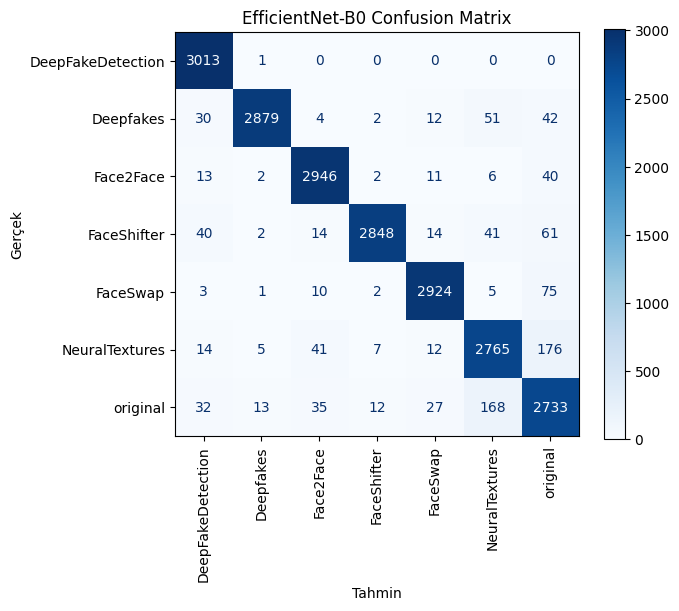

                   precision    recall  f1-score   support

DeepFakeDetection       0.96      1.00      0.98      3014
        Deepfakes       0.99      0.95      0.97      3020
        Face2Face       0.97      0.98      0.97      3020
      FaceShifter       0.99      0.94      0.97      3020
         FaceSwap       0.97      0.97      0.97      3020
   NeuralTextures       0.91      0.92      0.91      3020
         original       0.87      0.90      0.89      3020

         accuracy                           0.95     21134
        macro avg       0.95      0.95      0.95     21134
     weighted avg       0.95      0.95      0.95     21134

ROC AUC (micro): 0.9980 | ROC AUC (macro): 0.9973


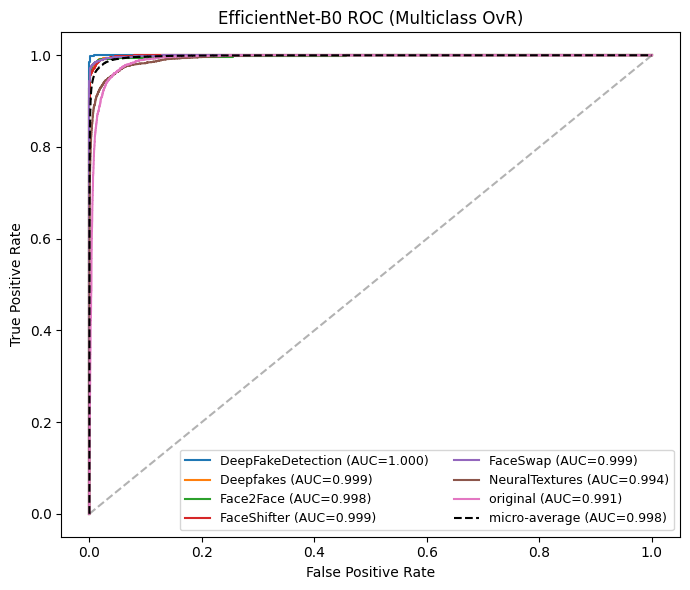

In [ ]:
# --- EfficientNet-B0 checkpoint ile TEST (best_efficientnet_b0.pth) ---
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# Checkpoint yolu
EFFICIENTNET_CKPT = "best_efficientnet_b0.pth"
if not os.path.isfile(EFFICIENTNET_CKPT):
    raise FileNotFoundError(f"EfficientNet checkpoint bulunamadı: {EFFICIENTNET_CKPT}")

# EfficientNet için ImageNet normalize (ResNet ile uyumlu)
efficientnet_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset / Loader
test_dataset_en = FaceForensicsDataset(
    DATA_ROOT, split="test", binary=BINARY, transform=efficientnet_test_transform
)
test_loader_en = DataLoader(test_dataset_en, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_classes_en = 2 if BINARY else len(test_dataset_en.class_names)
print("[EfficientNet] num_classes:", num_classes_en)

# Aynı mimariyi kur (checkpoint'i yükleyeceğiz, bu yüzden weights=None)
efficientnet_test = models.efficientnet_b0(weights=None)
efficientnet_test.classifier[1] = nn.Linear(efficientnet_test.classifier[1].in_features, num_classes_en)
efficientnet_test = efficientnet_test.to(device)

# Ağırlıkları yükle
state = torch.load(EFFICIENTNET_CKPT, map_location=device)
efficientnet_test.load_state_dict(state)
efficientnet_test.eval()

# Klasik test metrikleri (loss/acc)
criterion_en = nn.CrossEntropyLoss()
test_loss_en, test_acc_en = eval_one_epoch(efficientnet_test, test_loader_en, criterion_en, device)
print("[EfficientNet] Test loss:", test_loss_en, "Test acc:", test_acc_en)

# Confusion Matrix + ROC AUC
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader_en:
        images = images.to(device)
        outputs = efficientnet_test(images)
        probs = torch.softmax(outputs, dim=1)

        preds = probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Sınıf isimleri
class_names = (test_dataset_en.class_names
               if hasattr(test_dataset_en, "class_names") else
               [f"class_{i}" for i in range(all_probs.shape[1])])

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig_cm, ax_cm = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=(["Real", "Fake"] if num_classes_en == 2 else class_names))
disp.plot(ax=ax_cm, cmap="Blues", colorbar=True)
ax_cm.set_xlabel("Tahmin")
ax_cm.set_ylabel("Gerçek")
ax_cm.tick_params(axis="x", labelrotation=90)  # tahmin eksenindeki yazılar dik

plt.title("EfficientNet-B0 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

print(classification_report(
    all_labels, all_preds,
    target_names=(["Real", "Fake"] if num_classes_en == 2 else class_names)
))

# ROC AUC
if num_classes_en == 2:
    # Binary ROC (class-1: Fake)
    y_score = all_probs[:, 1]
    fpr, tpr, _ = roc_curve(all_labels, y_score, pos_label=1)
    roc_auc = roc_auc_score(all_labels, y_score)
    print(f"ROC AUC (binary): {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("EfficientNet-B0 ROC (Binary)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    # Multiclass ROC (OvR): micro + macro + per-class
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes_en)))
    probs_np = all_probs

    roc_auc_micro = roc_auc_score(y_true_bin, probs_np, average="micro")
    roc_auc_macro = roc_auc_score(y_true_bin, probs_np, average="macro")
    print(f"ROC AUC (micro): {roc_auc_micro:.4f} | ROC AUC (macro): {roc_auc_macro:.4f}")

    plt.figure(figsize=(7, 6))
    for i in range(num_classes_en):
        fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], probs_np[:, i])
        auc_i = roc_auc_score(y_true_bin[:, i], probs_np[:, i])
        plt.plot(fpr_i, tpr_i, label=f"{class_names[i]} (AUC={auc_i:.3f})")

    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs_np.ravel())
    plt.plot(fpr_micro, tpr_micro, color="black", linestyle="--",
             label=f"micro-average (AUC={roc_auc_micro:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("EfficientNet-B0 ROC (Multiclass OvR)")
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

In [19]:
# --- ResNet18 checkpoint ile TEST  ---



RESNET_CKPT = "best_resnet18b.pth"
if not os.path.isfile(RESNET_CKPT):
    raise FileNotFoundError(f"ResNet checkpoint bulunamadı: {RESNET_CKPT}")

# ResNet için ImageNet normalize
resnet_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset_rn = FaceForensicsDataset(
    DATA_ROOT, split="test", binary=BINARY, transform=resnet_test_transform
 )
test_loader_rn = DataLoader(test_dataset_rn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_classes_rn = 2 if BINARY else len(test_dataset_rn.class_names)
print("[ResNet] num_classes:", num_classes_rn)

# Aynı mimariyi kur (checkpoint'i yükleyeceğiz, bu yüzden weights=None)
resnet18_test = models.resnet18(weights=None)
resnet18_test.fc = nn.Linear(resnet18_test.fc.in_features, num_classes_rn)
resnet18_test = resnet18_test.to(device)

state = torch.load(RESNET_CKPT, map_location=device)
resnet18_test.load_state_dict(state)
resnet18_test.eval()

criterion_rn = nn.CrossEntropyLoss()
test_loss_rn, test_acc_rn = eval_one_epoch(resnet18_test, test_loader_rn, criterion_rn, device)
print("[ResNet] Test loss:", test_loss_rn, "Test acc:", test_acc_rn)

test sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
test split: 21134 örnek, binary=False
[ResNet] num_classes: 7


C:\Users\ynbiy\AppData\Local\Temp\ipykernel_17932\1306570743.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(RESNET_CKPT, map_location=device)


[ResNet] Test loss: 0.17383615815870437 Test acc: 0.9447336046181508


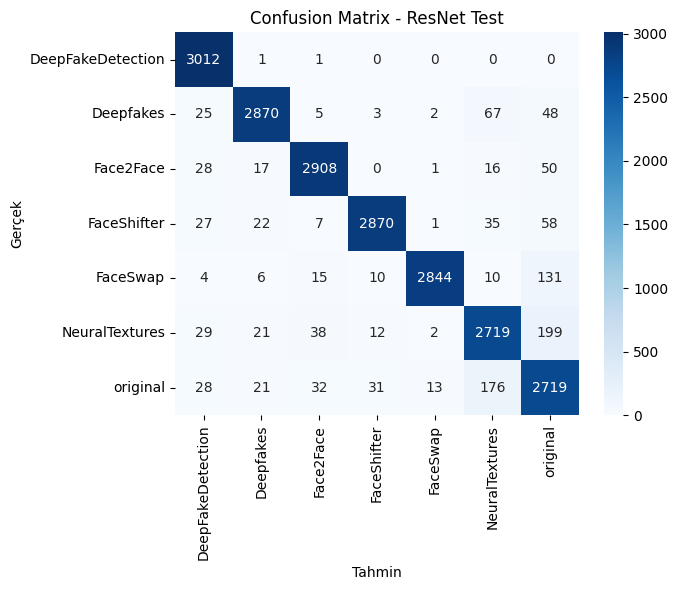

                   precision    recall  f1-score   support

DeepFakeDetection       0.96      1.00      0.98      3014
        Deepfakes       0.97      0.95      0.96      3020
        Face2Face       0.97      0.96      0.97      3020
      FaceShifter       0.98      0.95      0.97      3020
         FaceSwap       0.99      0.94      0.97      3020
   NeuralTextures       0.90      0.90      0.90      3020
         original       0.85      0.90      0.87      3020

         accuracy                           0.94     21134
        macro avg       0.94      0.94      0.94     21134
     weighted avg       0.94      0.94      0.94     21134



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



# Hangi resnet modeli varsa onu kullan
if "resnet18_test" in globals():
    cm_model = resnet18_test
elif "resnet18" in globals():
    cm_model = resnet18
else:
    raise RuntimeError("ResNet modeli bulunamadı (resnet18_test / resnet18 yok). Önce ResNet test hücresini çalıştır.")

if "test_loader_rn" not in globals() or "test_dataset_rn" not in globals():
    raise RuntimeError("test_loader_rn / test_dataset_rn yok. Önce ResNet TEST hücresini çalıştır.")

cm_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader_rn:
        images = images.to(device)
        outputs = cm_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

classes = test_dataset_rn.class_names
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix - ResNet Test")
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

In [12]:
test_dataset = FaceForensicsDataset(DATA_ROOT, split="test",
                                   binary=BINARY, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=0)

# SimpleFaceCNN ağırlığı yükle (ResNet checkpoint'i değil!)
CKPT_PATH = "best_face_cnn20.pth"

model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.to(device)
model.eval()



test sınıfları: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']
test split: 21134 örnek, binary=False


C:\Users\ynbiy\AppData\Local\Temp\ipykernel_30092\2872093685.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_location=dev

SimpleFaceCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [13]:
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)
print("Test loss:", test_loss, "Test acc:", test_acc)

Test loss: 0.36772656385320507 Test acc: 0.9000662439670672


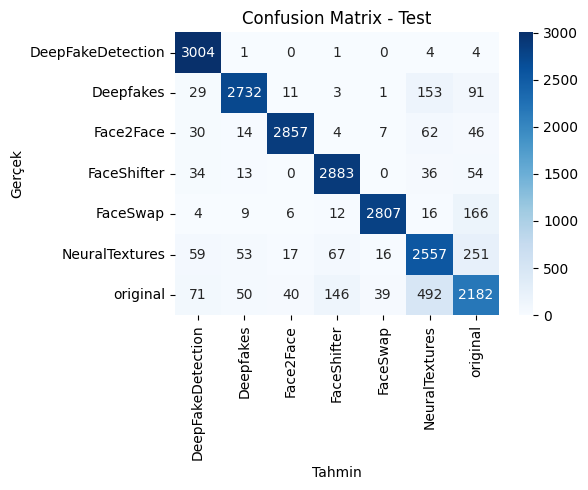

                   precision    recall  f1-score   support

DeepFakeDetection       0.93      1.00      0.96      3014
        Deepfakes       0.95      0.90      0.93      3020
        Face2Face       0.97      0.95      0.96      3020
      FaceShifter       0.93      0.95      0.94      3020
         FaceSwap       0.98      0.93      0.95      3020
   NeuralTextures       0.77      0.85      0.81      3020
         original       0.78      0.72      0.75      3020

         accuracy                           0.90     21134
        macro avg       0.90      0.90      0.90     21134
     weighted avg       0.90      0.90      0.90     21134



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:  # test_loader shuffle=False olmalı (şu an öyle)
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
classes = test_dataset.class_names

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix - Test")
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

Bulunan CSV'ler: ['celebdf_resultscnn.csv', 'celebdf_resultsefficent.csv', 'celebdf_resultsresnet.csv']


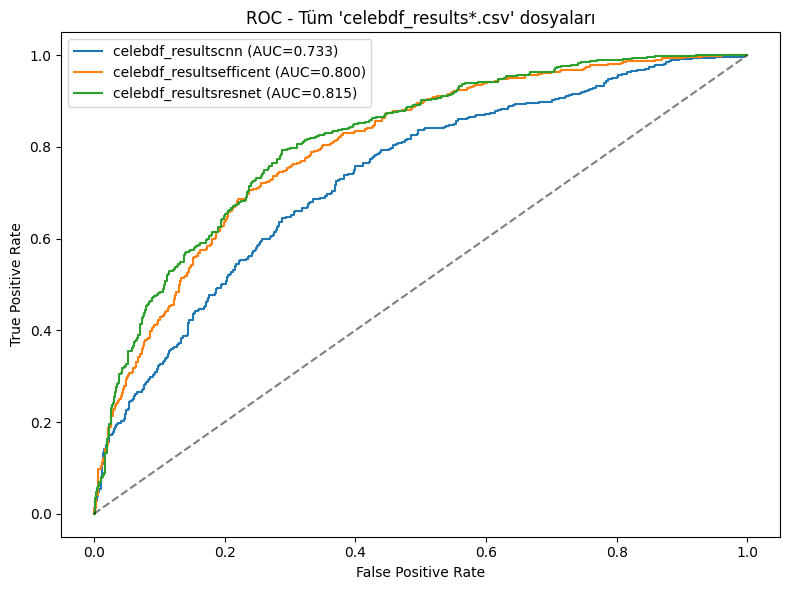

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from sklearn.metrics import (
        roc_curve, roc_auc_score,
        
    )
except Exception as e:
    raise RuntimeError("scikit-learn gerekli. Kurulu değilse: pip install scikit-learn") from e

def load_scores(csv_path):
    df = pd.read_csv(csv_path)

    if "y_true" not in df.columns:
        raise ValueError(f"CSV'de 'y_true' yok. Kolonlar: {list(df.columns)}")

    score_col = "fake_score"
    if "fake_score" not in df.columns:
        candidates = [c for c in df.columns if "score" in c.lower() or "prob" in c.lower()]
        if not candidates:
            raise ValueError(f"CSV'de 'fake_score' yok. Aday yok. Kolonlar: {list(df.columns)}")
        score_col = candidates[0]  # ilk uygun skor kolonu

    y_true = df["y_true"].astype(int).to_numpy()
    y_score = df[score_col].astype(float).to_numpy()

    uniq = np.unique(y_true)
    if not set(uniq).issubset({0, 1}):
        raise ValueError(f"y_true ikili değil. unique={uniq}. (ROC/PR için 0/1 bekleniyor)")

    return y_true, y_score

# Çalışma dizinindeki tüm 'celebdf_results*.csv' dosyalarını bul
csv_files = sorted([
    f for f in os.listdir(".")
    if f.startswith("celebdf_results") and f.lower().endswith(".csv")
])

if not csv_files:
    raise FileNotFoundError("Hiç 'celebdf_results*.csv' bulunamadı.")

print("Bulunan CSV'ler:", csv_files)

# --- Toplu ROC grafiği ---
plt.figure(figsize=(8, 6))
for f in csv_files:
    try:
        y_true, y_score = load_scores(f)
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{os.path.splitext(f)[0]} (AUC={auc:.3f})")
    except Exception as e:
        print(f"Atlandı: {f} -> {e}")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Tüm 'celebdf_results*.csv' dosyaları")
plt.legend()
plt.tight_layout()
plt.show()


Confusion matrix üretilecek CSV'ler: ['celebdf_resultscnn.csv', 'celebdf_resultsefficent.csv', 'celebdf_resultsresnet.csv']

[celebdf_resultscnn]   |    ROC AUC=0.7333 AP=0.7231 ACC=0.6703 F1=0.7175
Confusion Matrix (rows=true, cols=pred):
[[297 293]
 [ 96 494]]
              precision    recall  f1-score   support

        Real       0.76      0.50      0.60       590
        Fake       0.63      0.84      0.72       590

    accuracy                           0.67      1180
   macro avg       0.69      0.67      0.66      1180
weighted avg       0.69      0.67      0.66      1180



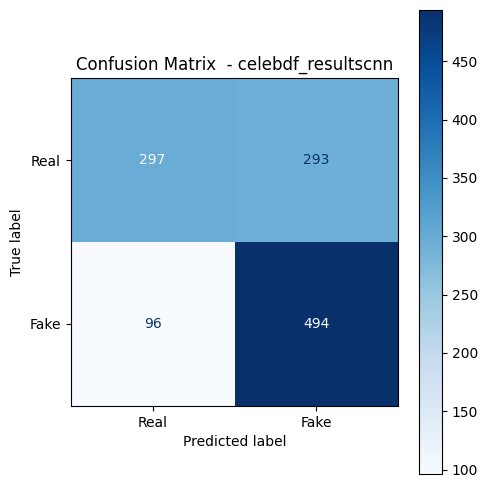


[celebdf_resultsefficent]   |    ROC AUC=0.8003 AP=0.7818 ACC=0.7136 F1=0.7533
Confusion Matrix (rows=true, cols=pred):
[[326 264]
 [ 74 516]]
              precision    recall  f1-score   support

        Real       0.81      0.55      0.66       590
        Fake       0.66      0.87      0.75       590

    accuracy                           0.71      1180
   macro avg       0.74      0.71      0.71      1180
weighted avg       0.74      0.71      0.71      1180



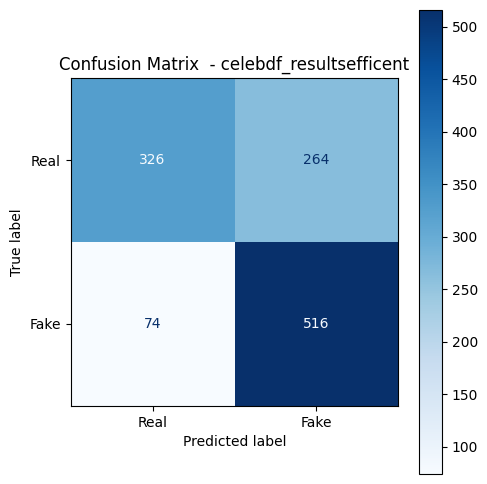


[celebdf_resultsresnet]   |    ROC AUC=0.8148 AP=0.7941 ACC=0.7458 F1=0.7627
Confusion Matrix (rows=true, cols=pred):
[[398 192]
 [108 482]]
              precision    recall  f1-score   support

        Real       0.79      0.67      0.73       590
        Fake       0.72      0.82      0.76       590

    accuracy                           0.75      1180
   macro avg       0.75      0.75      0.74      1180
weighted avg       0.75      0.75      0.74      1180



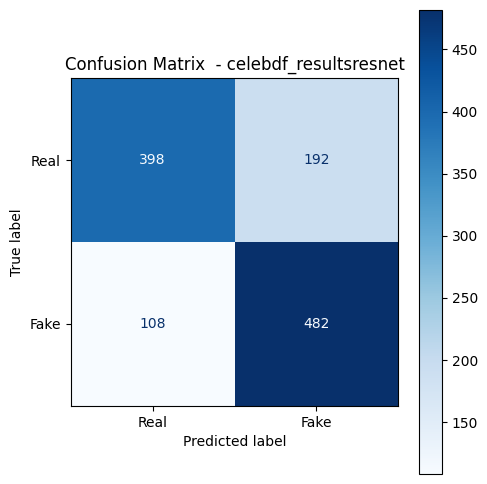

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

def load_scores(csv_path):
    df = pd.read_csv(csv_path)

    if "y_true" not in df.columns:
        raise ValueError(f"CSV'de 'y_true' yok. Kolonlar: {list(df.columns)}")

    score_col = "fake_score"
    if "fake_score" not in df.columns:
        candidates = [c for c in df.columns if "score" in c.lower() or "prob" in c.lower()]
        if not candidates:
            raise ValueError(f"CSV'de 'fake_score' yok. Aday yok. Kolonlar: {list(df.columns)}")
        score_col = candidates[0]

    y_true = df["y_true"].astype(int).to_numpy()
    y_score = df[score_col].astype(float).to_numpy()

    uniq = np.unique(y_true)
    if not set(uniq).issubset({0, 1}):
        raise ValueError(f"y_true ikili değil. unique={uniq}. (ROC/PR için 0/1 bekleniyor)")

    return y_true, y_score

# Tüm 'celebdf_results*.csv' dosyaları
csv_files = sorted([
    f for f in os.listdir(".")
    if f.startswith("celebdf_results") and f.lower().endswith(".csv")
])

if not csv_files:
    raise FileNotFoundError("Hiç 'celebdf_results*.csv' bulunamadı.")

print("Confusion matrix üretilecek CSV'ler:", csv_files)

for f in csv_files:
    try:
        y_true, y_score = load_scores(f)

        # ROC: Youden's J (TPR - FPR) ile threshold
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score, pos_label=1)
        j = tpr - fpr
        best_j_idx = int(np.argmax(j))
        best_thr_j = float(roc_thresholds[best_j_idx])

        # PR: F1-optimal threshold (varsa)
        prec, rec, pr_thresholds = precision_recall_curve(y_true, y_score)
        if len(pr_thresholds) > 0:
            f1s = []
            for thr in pr_thresholds:
                y_pred_thr = (y_score >= thr).astype(int)
                f1s.append(f1_score(y_true, y_pred_thr))
            best_f1_idx = int(np.argmax(f1s))
            best_thr_f1 = float(pr_thresholds[best_f1_idx])
            thr_cm = best_thr_f1
            thr_name = "F1-optimal"
            best_f1_val = float(f1s[best_f1_idx])
        else:
            best_thr_f1 = None
            thr_cm = best_thr_j
            thr_name = "Youden-J"
            best_f1_val = None

        # Tahmin (threshold ile)
        y_pred_cm = (y_score >= thr_cm).astype(int)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred_cm, labels=[0, 1])

        # Bilgi yazdır
        roc_auc = roc_auc_score(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        acc = (cm[0,0] + cm[1,1]) / cm.sum()

        print(f"\n[{os.path.splitext(f)[0]}]   |    "
              f"ROC AUC={roc_auc:.4f} AP={ap:.4f} ACC={acc:.4f}"
              + (f" F1={best_f1_val:.4f}" if best_f1_val is not None else ""))

        print("Confusion Matrix (rows=true, cols=pred):")
        print(cm)
        print(classification_report(y_true, y_pred_cm, target_names=["Real", "Fake"]))

        # Plot
        fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
        disp.plot(ax=ax_cm, cmap="Blues", colorbar=True)
        plt.title(f"Confusion Matrix  - {os.path.splitext(f)[0]}")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Atlandı: {f} -> {e}")